# Country-level Analysis of beyond-GDP Metrics

In [88]:
# Stdlib imports
from pathlib import Path
from itertools import combinations
from typing import Dict, List

# 3rd party imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## WISE data analysis with Focus on Switzerland

In [2]:
# Set up file paths
data_root = Path("../../data")
wisedb_path = data_root / "WISE/Data/WISE_Database/"

In [3]:
# Read the WISE database into memory
wise_db = dict()

for sheet in ["Content", "Metrics Info", "C Data", "CG Data", "Metrics C&CG", "C&CG Code"]:
    wise_db[sheet] = pd.read_excel(wisedb_path / "WISE_Database.xlsx", sheet_name=sheet)

In [4]:
# Filter data for Switzerland (ISO3 = "CHE")
wise_ch = wise_db["C Data"].loc[wise_db["C Data"]["ISO3"].values == "CHE"]

In [5]:
# Split dataframe into dictionary of dataframes. Each key-value pair belongs to a specific indicator
wise_ch_ind__raw = dict()

for acr in wise_ch["Acronym"].unique():
    wise_ch_ind__raw[acr] = wise_ch.loc[wise_ch["Acronym"]==acr]

# Current number of indicators
len(wise_ch_ind__raw.keys())

238

### Data Cleaning

#### Step 1: Ignore indices that have not been recorded for at least 10 years (i.e. 10 data points)

In [6]:
wise_ch_ind__statrel = ({k: v for (k,v) in wise_ch_ind__raw.items() if len(v["Year"])>=10})

# Current number of indicators
len(wise_ch_ind__statrel.keys())

226

In [7]:
# Removed indicators
set(wise_ch_ind__raw.keys()) - set(wise_ch_ind__statrel.keys())

{'CLIO-CMW-HEIGHT',
 'WB-WDI-EN-BIR-THRD-NO',
 'WB-WDI-EN-FSH-THRD-NO',
 'WB-WDI-EN-HPT-THRD-NO',
 'WB-WDI-EN-MAM-THRD-NO',
 'WB-WDI-ER-LND-PTLD-ZS',
 'WB-WDI-GB-XPD-RSDV-GD-ZS',
 'WB-WDI-HD-HCI-OVRL',
 'WB-WDI-SE-PRM-CUAT-ZS',
 'WB-WDI-SH-PRV-SMOK',
 'WB-WDI-SM-POP-TOTL-ZS',
 'WB-WDI-SP-POP-SCIE-RD-P6'}

#### Step 2: Ignore constant indices

In [8]:
wise_ch_ind__nonconst = ({k: v for (k,v) in wise_ch_ind__statrel.items() if v["Value"].std()>0})

# Current number of indicators
len(wise_ch_ind__nonconst.keys())

200

In [9]:
# Removed indicators
set(wise_ch_ind__statrel.keys() - set(wise_ch_ind__nonconst.keys()))

{'CLIO-CMW-POLITY2',
 'FAN-DEF-EC-CO2-THRES',
 'FAN-DEF-SF-DQ-THRES',
 'FAN-DEF-SF-ED-THRES',
 'FAN-DEF-SF-EM-THRES',
 'FAN-DEF-SF-EN',
 'FAN-DEF-SF-EN-RATIO',
 'FAN-DEF-SF-EN-THRES',
 'FAN-DEF-SF-EQ-THRES',
 'FAN-DEF-SF-IN-RATIO',
 'FAN-DEF-SF-IN-THRES',
 'FAN-DEF-SF-LE-THRES',
 'FAN-DEF-SF-LS-THRES',
 'FAN-DEF-SF-NU-THRES',
 'FAN-DEF-SF-SA-RATIO',
 'FAN-DEF-SF-SA-THRES',
 'FAN-DEF-SF-SS-THRES',
 'WB-CWON-NCA-FISH-PC',
 'WB-CWON-NCA-FISH-TO',
 'WB-CWON-NCA-MANG-PC',
 'WB-CWON-NCA-MANG-TO',
 'WB-CWON-NCA-SACO-PC',
 'WB-CWON-NCA-SACO-TO',
 'WB-CWON-NCA-SAOI-PC',
 'WB-CWON-NCA-SAOI-TO',
 'WB-WDI-EG-ELC-ACCS-ZS'}

#### Step 3: Split by capital

In [10]:
four_capitals = ["Human", "Social", "Natural", "Economic"]

In [11]:
# Define mapping from WISE categories to four capitals:
# Wellbeing -> Human
# Inclusion -> Social
# Sustainability -> Natural
# Economy and Society -> Economic
capital_map = {"Human": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Wellbeing"] == "X", "Acronym"].values),
               "Social": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Inclusion"] == "X", "Acronym"].values),
               "Natural": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Sustainability"] == "X", "Acronym"].values),
               "Economic": list(wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Economy and Society"] == "X", "Acronym"].values)
              }

In [12]:
# Create a dictionary with a key-value pair for each capital
wise_capitals_ch = dict()

for cap in four_capitals:
    cap_dict = {k: v for (k,v) in wise_ch_ind__nonconst.items() if k in capital_map[cap]}
    wise_capitals_ch[cap] = pd.concat(cap_dict, ignore_index=True)\
                              .pivot(index="Acronym", columns="Year", values="Value")\
                              .astype(float)
    wise_capitals_ch[cap].columns.astype(int)
    wise_capitals_ch[cap] = wise_capitals_ch[cap][sorted(wise_capitals_ch[cap].columns)]

    # Fix time axis: Include every year between minimal and maximal year
    min_year = wise_capitals_ch[cap].columns.min()
    max_year = wise_capitals_ch[cap].columns.max()
    full_years = list(range(min_year, max_year + 1))

    # Reindex columns to include every year (adds NaNs where data is missing)
    wise_capitals_ch[cap] = wise_capitals_ch[cap].reindex(columns=full_years)

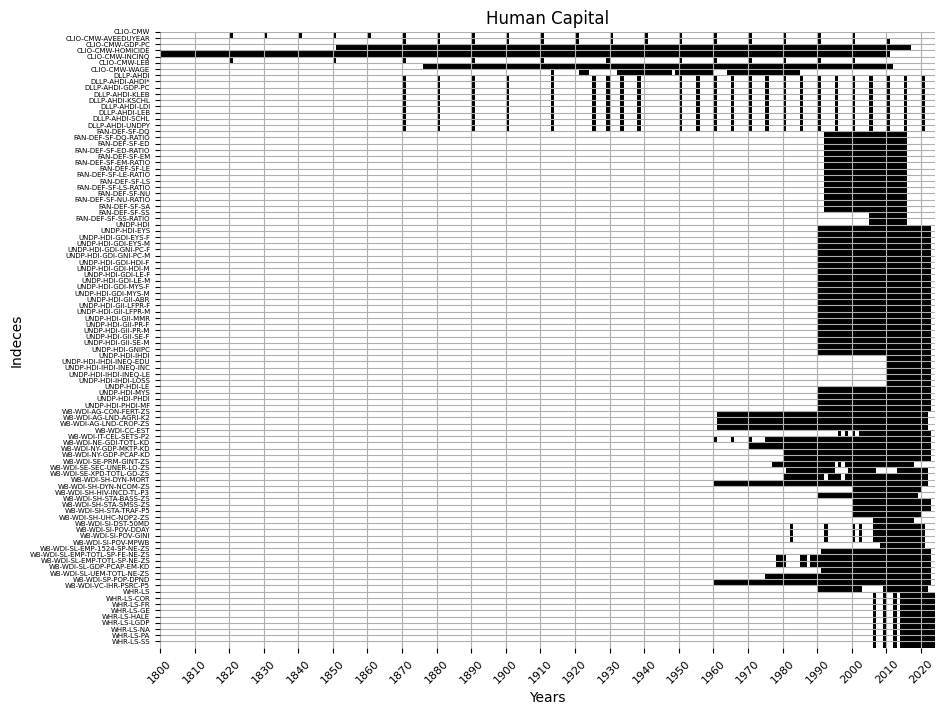

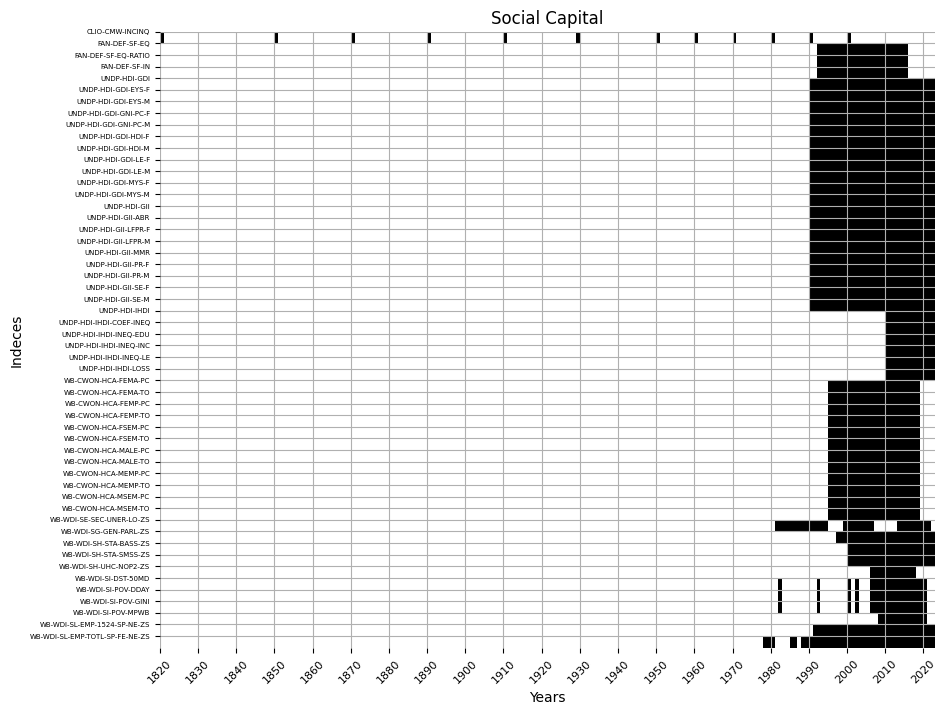

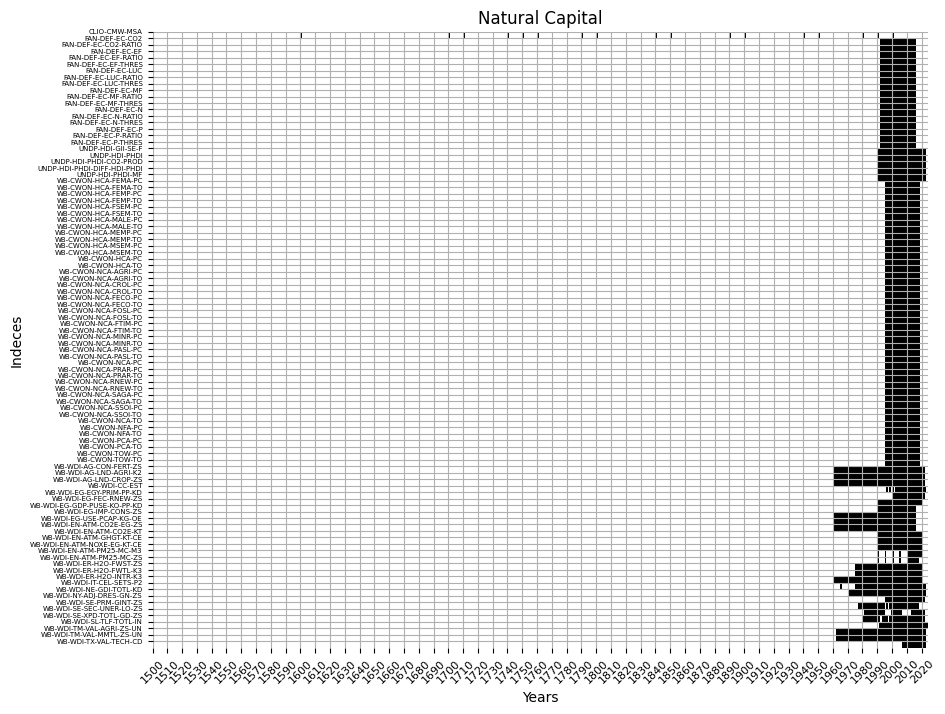

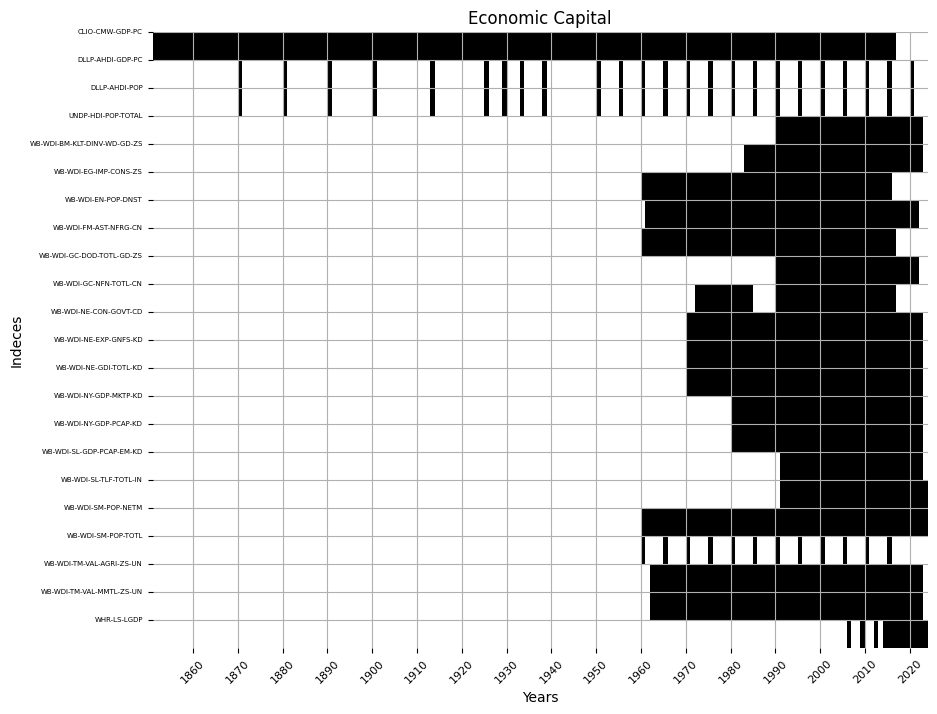

In [18]:
for cap in four_capitals:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(wise_capitals_ch[cap].isnull(), 
                cbar=False,        # Hide color bar
                cmap=['black', 'white'],  # black = not null, white = null
                xticklabels = True,
                yticklabels = True,
                ax=ax)
    
    ax.grid(True)

    # Set axis ticks (for x axis: plot only decades)
    tick_locs = [i for i, year in enumerate(wise_capitals_ch[cap].columns) if year % 10 == 0]
    tick_labels = [str(year) for year in wise_capitals_ch[cap].columns if year % 10 == 0]
    
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)
    
    ax.set_yticks(range(len(wise_capitals_ch[cap].index)))
    ax.set_yticklabels(wise_capitals_ch[cap].index, fontsize=5)

    # Add axis lables
    ax.set_xlabel("Years")
    ax.set_ylabel("Indeces")

    # Add title
    ax.set_title(cap + " Capital")
    #fig.savefig("./valueAvailabilityMap_" + cap + "Capital.pdf")

Looking at these graphics it becomes evident that the data availability is quite good after starting in the year 1995. For this reason, I shall interpolate metrics wherever possible in order to maximize the data availability between 1995 and 2025. Then, this is the time window I focus on in the subsequent analysis.

Obviously, this strategy ignores a number of metrics. In the future, one could think of finding other time windows where ignored metrics could be correlated with metrics that have been taken into account in order to get a sense of whether those metrics contain relevant information content or not.

#### Step 4: Removing metrics with insufficient availability

In [15]:
# Remove indicators with no data whatsoever prior to 1995
wise_capitals_ch_reduced = dict()

for cap in four_capitals:
    wise_capitals_ch_reduced[cap] = wise_capitals_ch[cap].copy()
    tmp = wise_capitals_ch_reduced[cap].loc[:,wise_capitals_ch_reduced[cap].columns < 1995].dropna(axis="rows", how="all")
    wise_capitals_ch_reduced[cap] = wise_capitals_ch[cap].loc[wise_capitals_ch[cap].index.isin(tmp.index),:]

#### Step 5: Interpolation of metrics

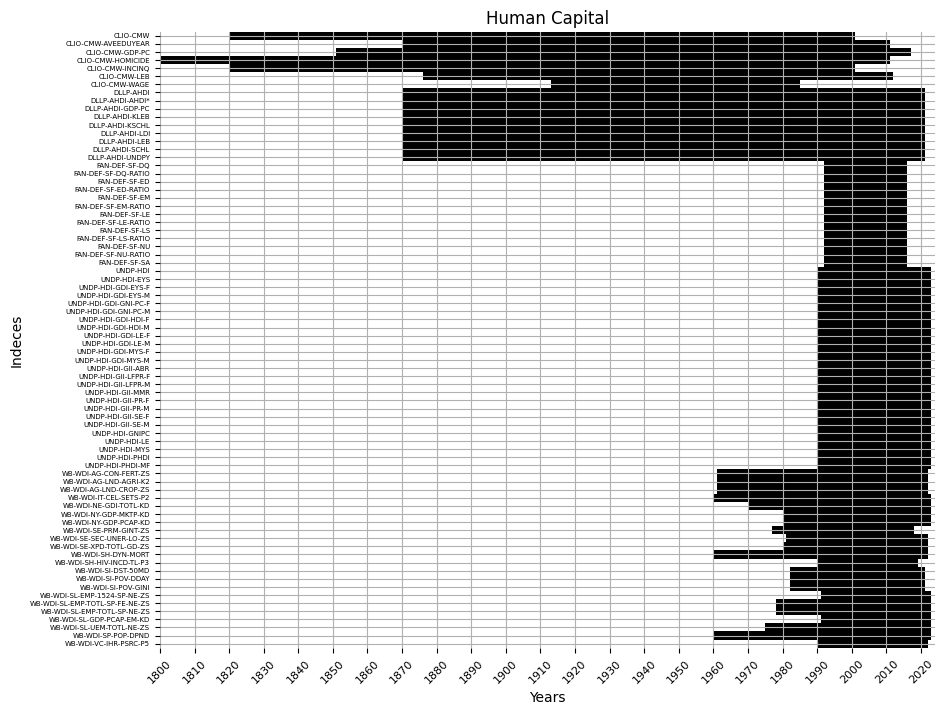

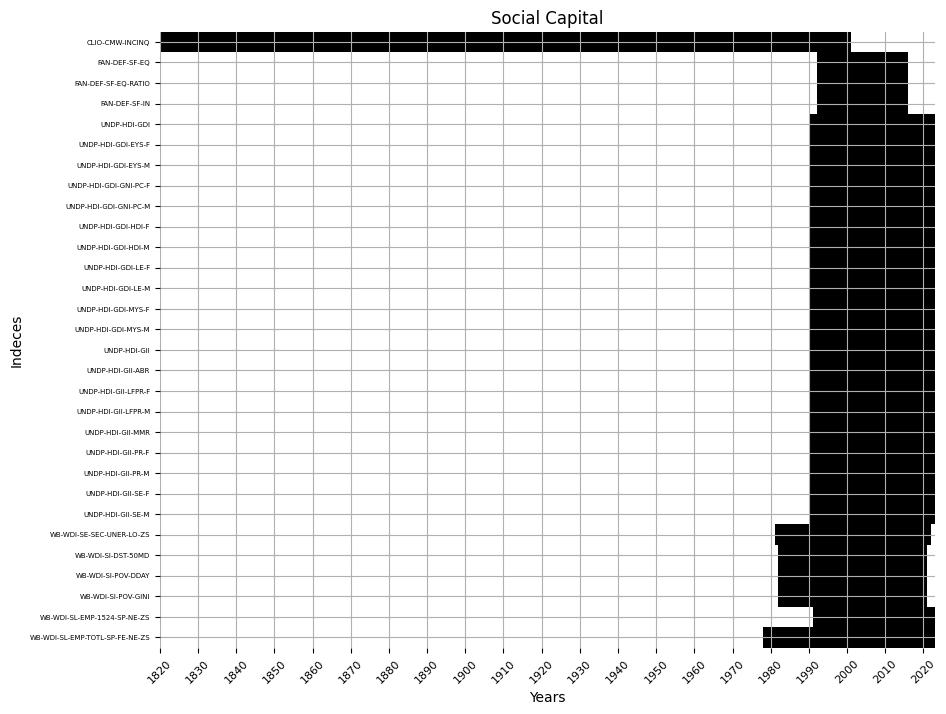

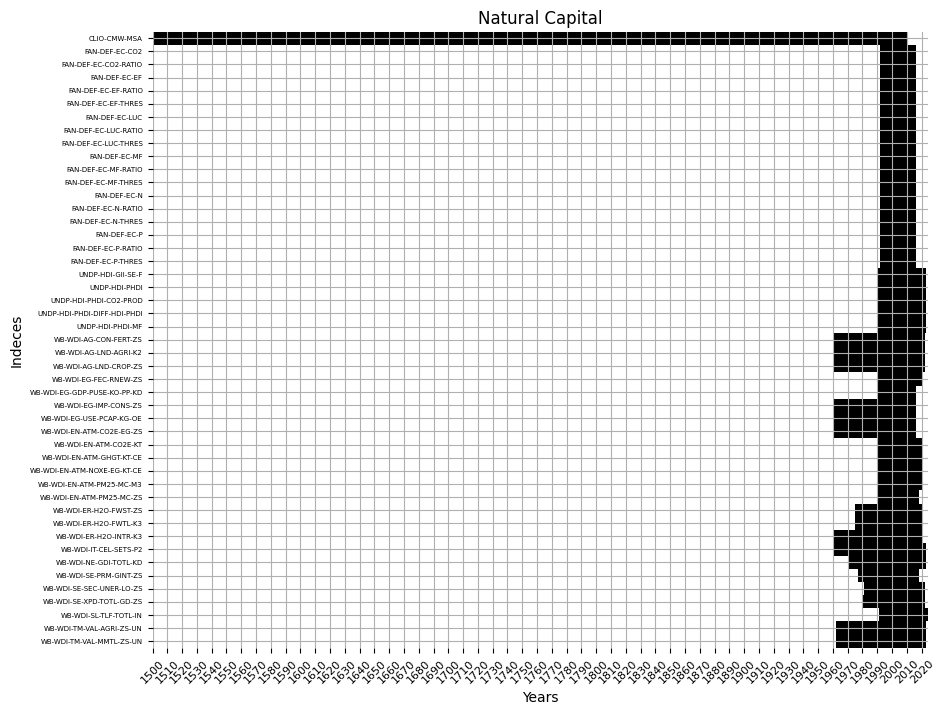

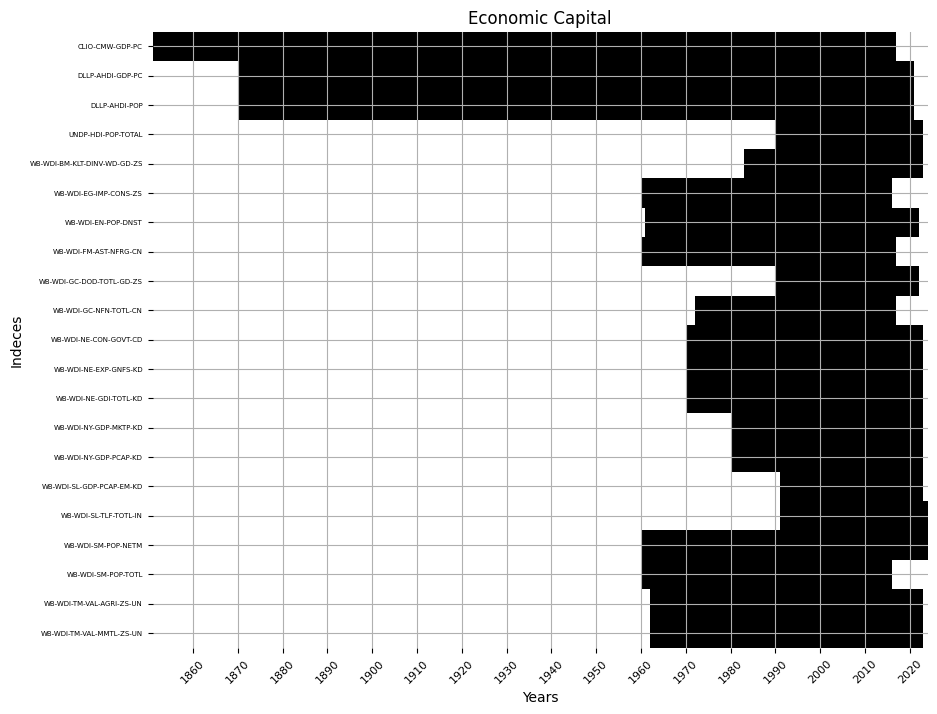

In [19]:
# Interpolate data between 1995 and 2025
wise_capitals_ch_interp = dict()

for cap in four_capitals:
    wise_capitals_ch_interp[cap] = wise_capitals_ch_reduced[cap]\
                                        .astype(float)\
                                        .interpolate("linear",axis="columns", limit_area="inside")

    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(wise_capitals_ch_interp[cap].isnull(), 
                cbar=False,        # Hide color bar
                cmap=['black', 'white'],  # black = not null, white = null
                yticklabels=True,
                ax=ax)
    
    ax.grid(True)

    tick_locs = [i for i, year in enumerate(wise_capitals_ch_interp[cap].columns) if year % 10 == 0]
    tick_labels = [str(year) for year in wise_capitals_ch_interp[cap].columns if year % 10 == 0]
    
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)
    
    ax.set_yticklabels(wise_capitals_ch_interp[cap].index,fontsize=5)
    ax.set_xlabel("Years")
    ax.set_ylabel("Indeces")
    ax.set_title(cap + " Capital")
    #fig.savefig("./valueAvailabilityMap_" + cap + "Capital__afterInterpolation.pdf")

#### Step 6: Remove Metrics That are missing values between 1995 and 2025

In [20]:
wise_capitals_ch_clean = dict()

for cap in four_capitals:
    time_window = [a and b for (a,b) in zip(wise_capitals_ch_interp[cap].columns>=1995, 
                                            wise_capitals_ch_interp[cap].columns<=2020)
                  ]
    wise_capitals_ch_clean[cap] = wise_capitals_ch_interp[cap].loc[:, time_window].dropna(axis="rows", how="any")

### Sanity check:

In [21]:
print("Are there any NULL values left?")
for cap in four_capitals:
    print(f"{cap}: {wise_capitals_ch_clean[cap].isnull().any().any()}")

Are there any NULL values left?
Human: False
Social: False
Natural: False
Economic: False


In [22]:
n_metrics = 0
for cap in four_capitals:
    n_metrics += wise_capitals_ch_clean[cap].shape[0]

n_metrics

118

#### Step 7: Ignore again constant indices (if present)
Notice: In the next step we also transpose the matrices such that the various indicators and indices (features) are stored in the columns while the different years (i.e. different observations) are stored in rows as is customary in machine learning community.

In [72]:
for cap in four_capitals:
    df = wise_capitals_ch_clean[cap].transpose()
    wise_capitals_ch_clean[cap] = df.loc[:, (df != df.iloc[0]).any()]

## Correlation analysis within Capitals

In [109]:
class CorrelationAnalysis(object):
    def __init__(self, data: dict[str, pd.DataFrame], name_map=None, timeseries=True):
        self.data = data
        self.classes = self.data.keys()
        self.is_timeseries = timeseries
        self.name_map = name_map
    
    def compute_correlation(self):
        self.corrmats = dict()
        for cl in self.classes:
            if self.is_timeseries:
                # use pct_change method to detrend the timeseries
                self.corrmats[cl] = self.data[cl].pct_change().corr()
            else:
                self.corrmats[cl] = self.data[cl].corr()

    def plot_corr_heatmap(self, title_root: str, use_name_map: bool = False, mask: Dict["str", List["str"]] = None):
        for cl in self.classes:
            df = self.corrmats[cl]
            if mask:
                assert mask.keys() == self.classes
                df = df.loc[mask[cl], mask[cl]]
            
            if use_name_map:
                df = df.rename(idx_name_map, axis=1).rename(idx_name_map, axis=0)
                
            fig, ax = plt.subplots(figsize=(10,9))    
            sns.heatmap(df, vmin=-1, vmax=1, ax=ax)
            ax.set_title(cap + " Capital")
            plt.tight_layout()

            fig_title = "./" + title_root + "_" + cl + "Capital"
            if self.is_timeseries:
                fig_title += "_detrended"
                
            #fig.savefig(fig_title + ".pdf")

    def drop_strong_correlations(self, threshold: float):
        """
        Filter which indices to keep and which ones to drop
        """
        keepers = dict()
        droppers = dict()
        
        for cl in self.classes:
            indices = self.corrmats[cl].index
            keepers[cl] = []
            droppers[cl] = []
            for (i1, i2) in combinations(indices,2):
                keepers[cl].append(i1)
                if np.abs(self.corrmats[cl].loc[i1,i2])>threshold:
                    droppers[cl].append(i2)
        
            droppers[cl] = set(droppers[cl])
            keepers[cl] = list(set(keepers[cl]) - droppers[cl])

        return keepers

    df_dict = dict()


for cap in four_capitals:
    for idx in keepers[cap]:
        corr_series = corr_matrices[cap][idx]
        strong_corr = corr_series[np.abs(corr_series)>0.9]
        
        if len(strong_corr)==1:
            continue
        tmp = strong_corr.to_frame()\
            .reset_index()\
            .rename({"index": "Acronym"}, axis=1)\
            .merge(wise_db["Metrics Info"][["Acronym", "Metric Full Name"]], 
                   on="Acronym", 
                   how="inner"
                  )
        
        current_full_name = wise_db["Metrics Info"].loc[wise_db["Metrics Info"]["Acronym"]==idx, "Metric Full Name"].values[0]
        
        corr_df = tmp[[idx, "Metric Full Name"]].rename({idx: "Correlation Coefficient"}, axis=1)
        corr_df = corr_df[["Metric Full Name", "Correlation Coefficient"]]
        corr_df = corr_df.style.set_caption("Indices strongly correlated with: " + current_full_name)
        df_dict[current_full_name] = corr_df

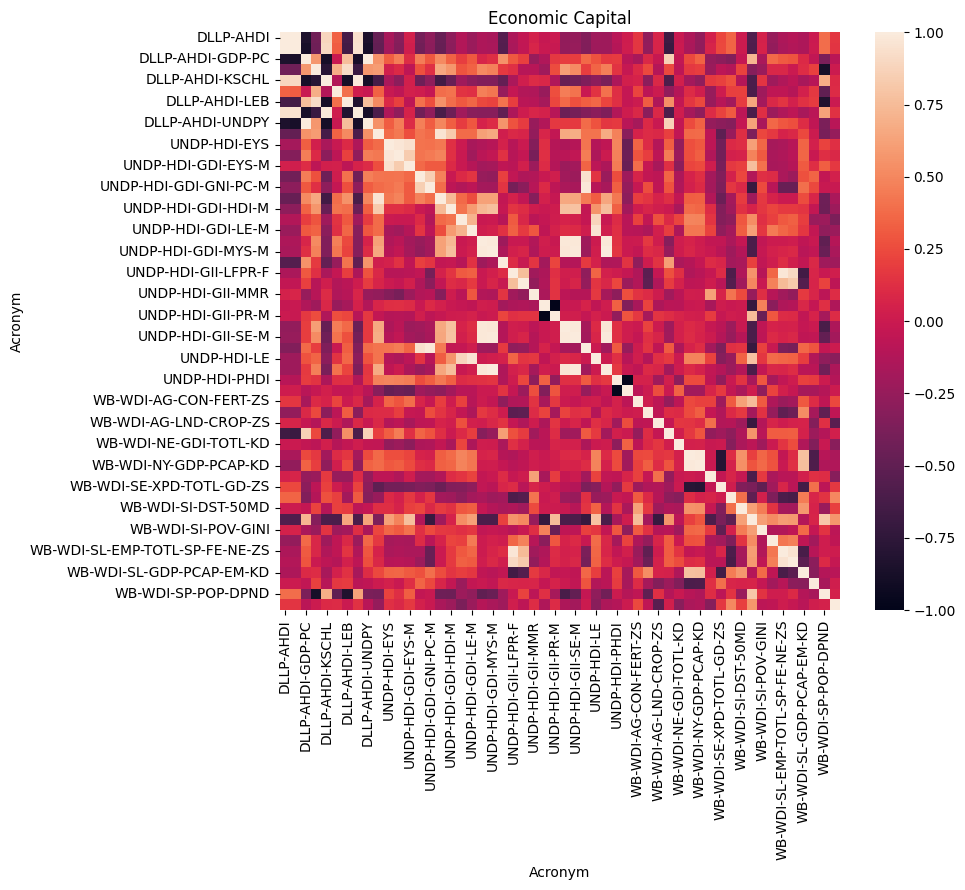

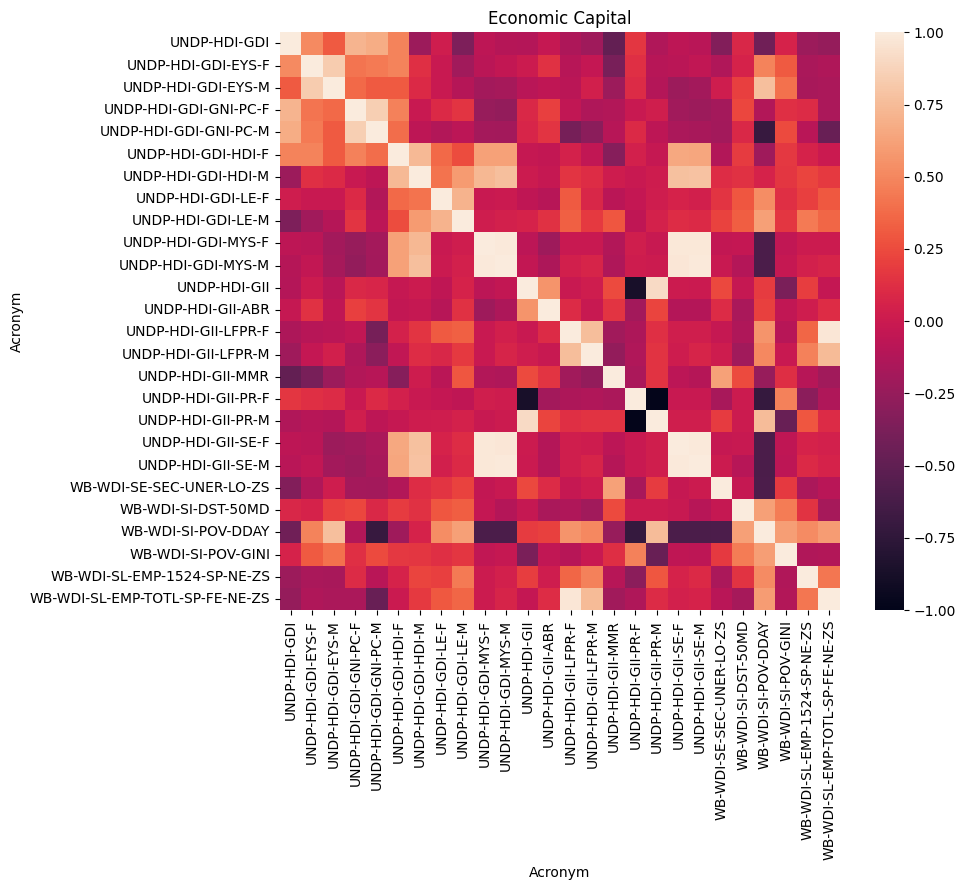

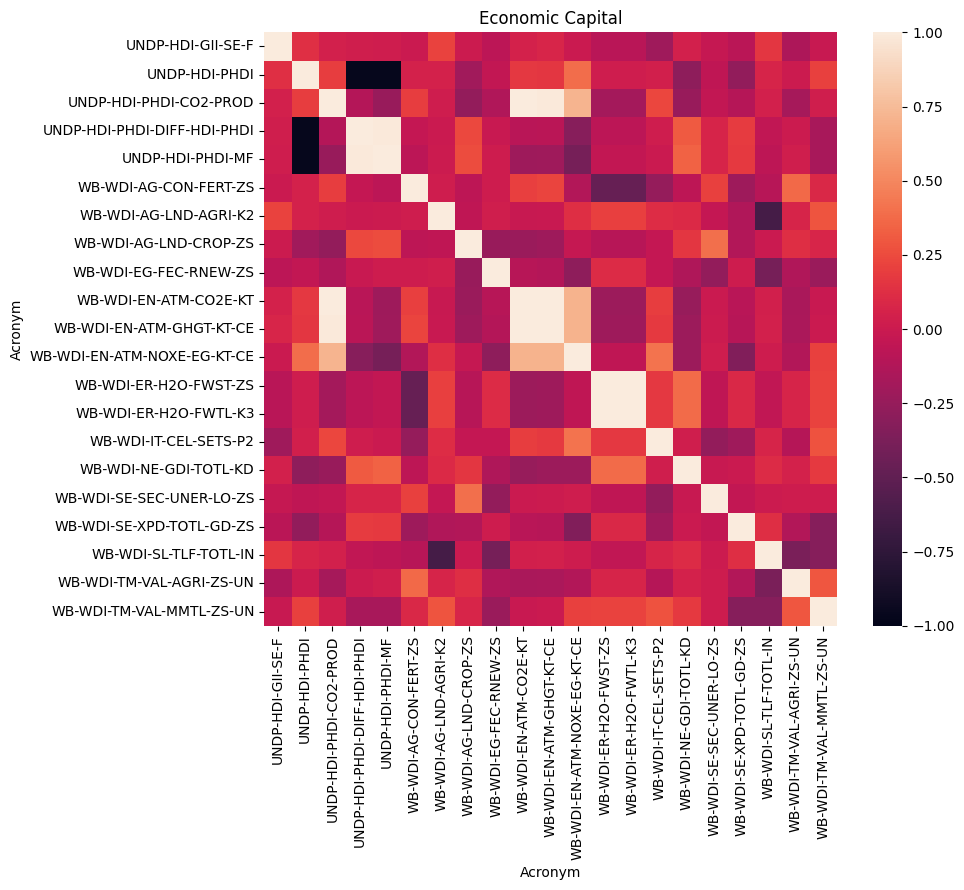

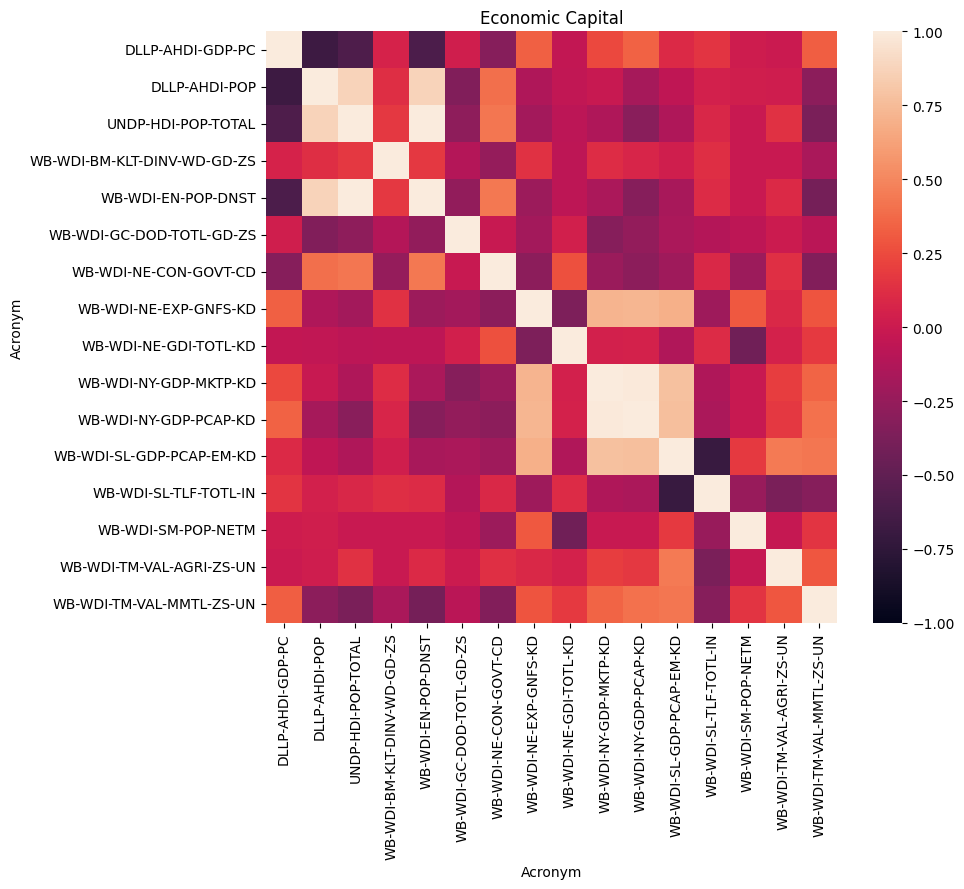

In [110]:
idx_name_map = {k: v for [k,v] in wise_db["Metrics Info"][["Acronym", "Metric Full Name"]].to_dict(orient="tight")["data"]}

ca = CorrelationAnalysis(wise_capitals_ch_clean, name_map = idx_name_map)
ca.compute_correlation()
ca.plot_corr_heatmap(title_root="corrMat")

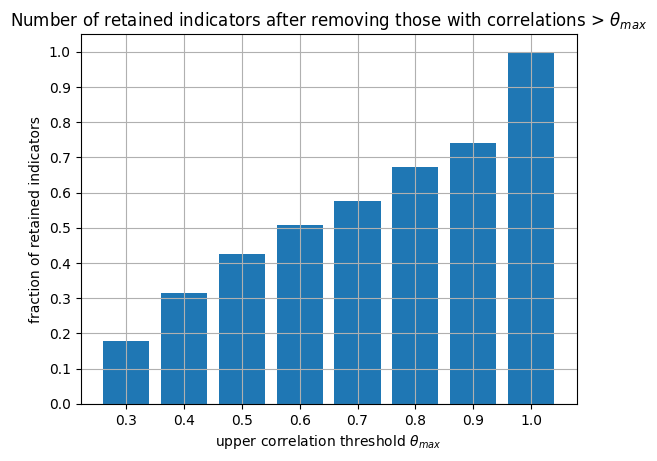

In [146]:
corr_thrsh = [i/10 for i in range(3,11)]
len_keepers = []
for thr in corr_thrsh:
    keepers = ca.drop_strong_correlations(thr)
    len_keepers.append(len(set([elm for sl in [l for k, l in keepers.items()] for elm in sl])))

# Compute maximum for normalization
max_count = max(len_keepers)
fractions = [count / max_count for count in len_keepers]

fig, ax = plt.subplots()
ax.bar(range(len(corr_thrsh)),height=fractions)
ax.grid(True)

ax.set_xticks(range(len(corr_thrsh)))
ax.set_xticklabels(corr_thrsh)
ax.set_xlabel(r"upper correlation threshold $\theta_{max}$")

ax.set_yticks([i/10 for i in range(11)])
ax.set_yticklabels([i/10 for i in range(11)])
ax.set_ylabel("fraction of retained indicators")

ax.set_title(r"Number of retained indicators after removing those with correlations > $\theta_{max}$")
plt.show()

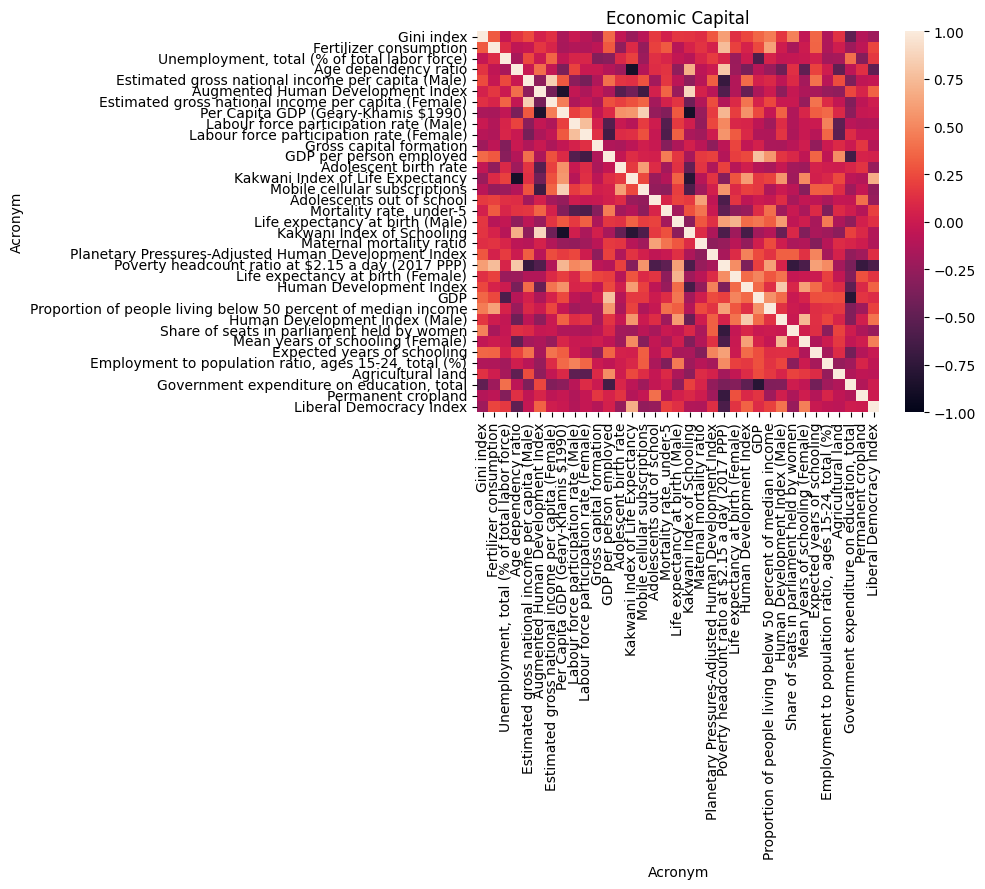

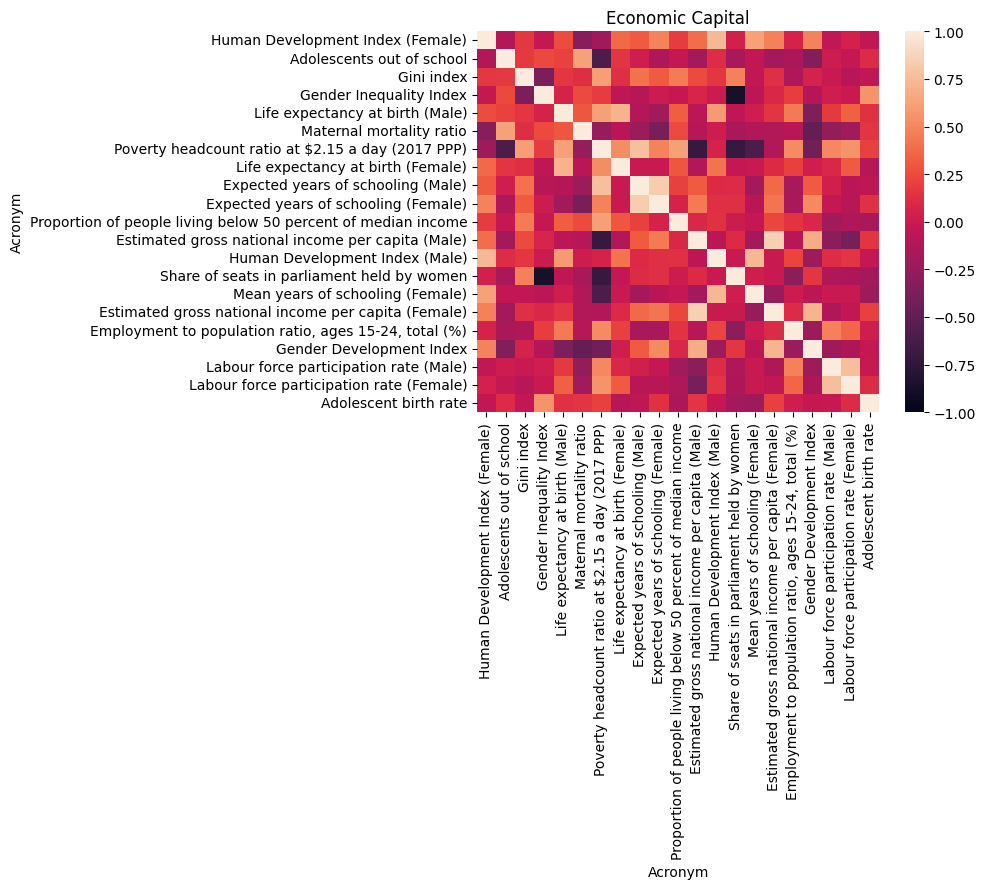

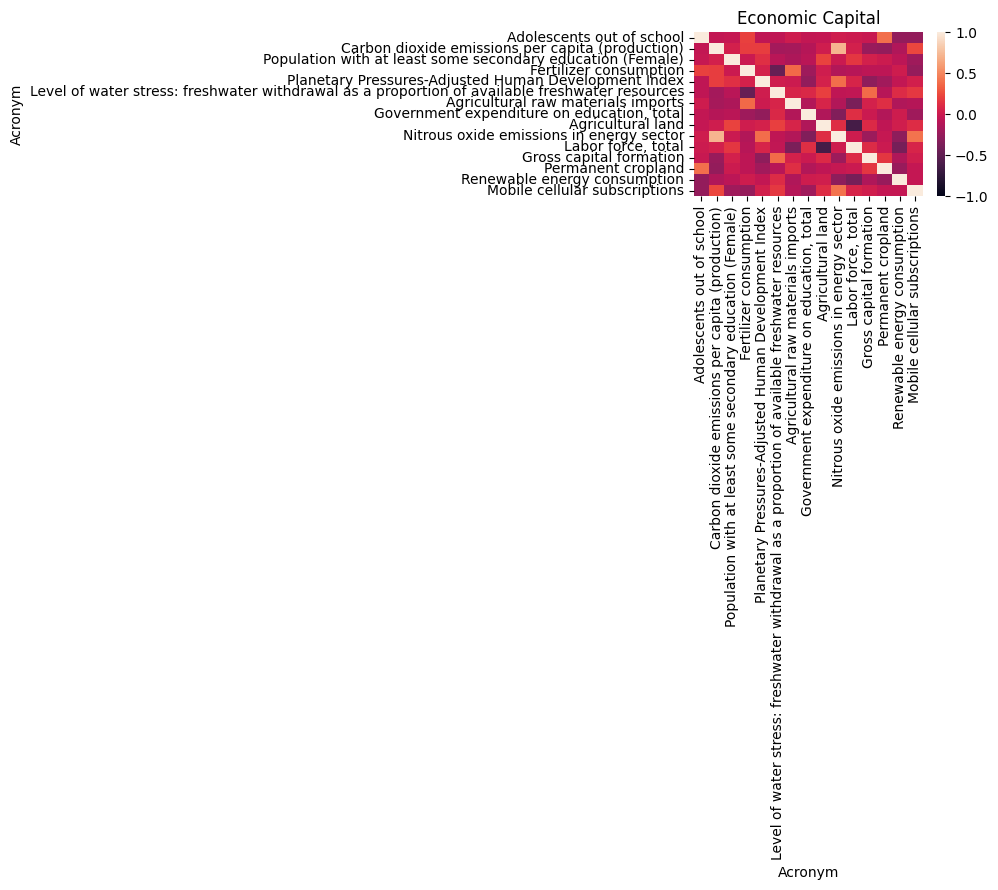

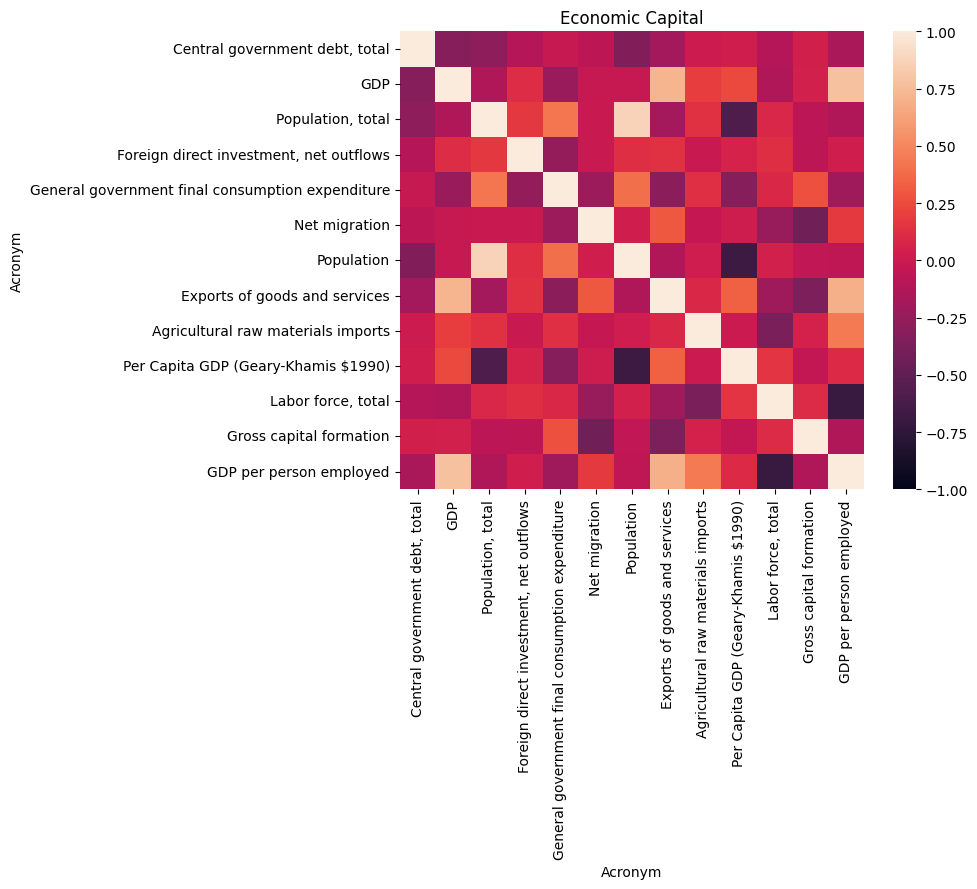

In [147]:
keepers = ca.drop_strong_correlations(0.9)
ca.plot_corr_heatmap(title_root="RelevantIndicators_corrMatrix", use_name_map = True, mask=keepers)

In [148]:
print("Number of remaining indicators per capital:")
for cap in four_capitals:
    print(cap + ":", len(keepers[cap]))
print()
print("Total number of remaining indicators (excluding duplicates):", len(set([elm for sl in [l for k, l in keepers.items()] for elm in sl])))

Number of remaining indicators per capital:
Human: 35
Social: 21
Natural: 15
Economic: 13

Total number of remaining indicators (excluding duplicates): 54


In [152]:
with pd.ExcelWriter('correlated_indicators_after_detrending.xlsx') as writer:
    for sheet_name, df in df_dict.items():
        print(sheet_name)
        df.to_excel(writer, sheet_name=sheet_name.replace(":","--"), index=False)

Estimated gross national income per capita (Male)
Augmented Human Development Index
Estimated gross national income per capita (Female)
Per Capita GDP (Geary-Khamis $1990)
Labour force participation rate (Female)
Kakwani Index of Life Expectancy
Life expectancy at birth (Male)
Kakwani Index of Schooling
Planetary Pressures-Adjusted Human Development Index
Human Development Index
GDP
Share of seats in parliament held by women
Mean years of schooling (Female)
Expected years of schooling
Gender Inequality Index
Carbon dioxide emissions per capita (production)
Level of water stress: freshwater withdrawal as a proportion of available freshwater resources
Population, total
